In [1]:
import torch
import pandas as pd
import gc
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from model.classifier import Net

from torch.autograd import Variable

from matplotlib import pyplot

from tqdm import tqdm

/tmpscratch/tkim12/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
file_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

# Load background
bkg_file = 400
CMB_bkg = []
for file_num in range(bkg_file):
    Xtemp = np.load(file_loc+"quicklens_backgound/500_events_90Sqr_lensed_Backgroundlmax3500_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_bkg.append(Xtemp[k])


# Load CMB signal only (g = 1)
CMB_sig = []
for file_num in range(1,201):
    Xtemp = np.load(file_loc+"PHS_signal/500_PHS_g1_Sig_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_sig.append(Xtemp[k])

In [4]:
CMB_bkg = np.array(CMB_bkg)
CMB_sig = np.array(CMB_sig)

CMB_bkg_num = CMB_bkg.shape[0]


# Prepare pure background and background + signal
rescale_val = 2

bkgonly = CMB_bkg[0:int(CMB_bkg_num/2)]
SpB = CMB_bkg[int(CMB_bkg_num/2):]+ rescale_val *CMB_sig

bkg_indicator = np.zeros(int(CMB_bkg_num/2))
sig_indicator = np.ones(int(CMB_bkg_num/2))

In [7]:
spbmean = []
bkgmean = []

for ii in range(len(SpB)):
    spbmean.append(np.mean(SpB[ii]))
    bkgmean.append(np.mean(bkgonly[ii]))

spbmean = np.array(spbmean)
bkgmean = np.array(bkgmean)

(array([1.000e+00, 2.000e+00, 8.000e+00, 1.200e+01, 2.700e+01, 4.400e+01,
        7.500e+01, 1.280e+02, 1.970e+02, 2.670e+02, 4.390e+02, 6.580e+02,
        1.023e+03, 1.322e+03, 1.828e+03, 2.338e+03, 2.993e+03, 3.716e+03,
        4.392e+03, 5.109e+03, 5.725e+03, 6.316e+03, 6.677e+03, 6.853e+03,
        6.940e+03, 6.705e+03, 6.390e+03, 5.698e+03, 5.038e+03, 4.336e+03,
        3.646e+03, 2.954e+03, 2.293e+03, 1.759e+03, 1.361e+03, 9.500e+02,
        6.500e+02, 3.990e+02, 2.950e+02, 1.650e+02, 1.160e+02, 6.600e+01,
        4.800e+01, 1.200e+01, 1.400e+01, 6.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00]),
 array([-112.80684415, -108.10128192, -103.39571969,  -98.69015745,
         -93.98459522,  -89.27903298,  -84.57347075,  -79.86790852,
         -75.16234628,  -70.45678405,  -65.75122181,  -61.04565958,
         -56.34009735,  -51.63453511,  -46.92897288,  -42.22341064,
         -37.51784841,  -32.81228618,  -28.10672394,  -23.40116171,
         -18.69559947,  -13.99003724

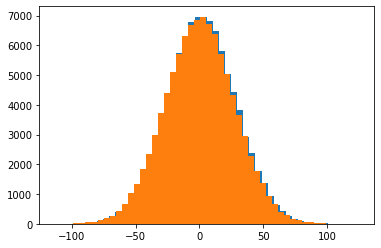

In [9]:
%matplotlib inline
plt.hist(spbmean,50)
plt.hist(bkgmean,50)

In [5]:
#plt.imshow(CMB_sig[4])
#plt.savefig('sample_img.pdf')
sig_indicator[100]

1.0

In [6]:
X_data = np.concatenate((bkgonly,      SpB          ))
Y_data = np.concatenate((bkg_indicator,sig_indicator))

wid, hei = X_data.shape[1], X_data.shape[2]

X_data, Y_data = shuffle(X_data, Y_data, random_state=23)

print(wid, hei)
#print(Y_data)

# Data Splitting
ts1 = 0.2
rs1 = 23
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = ts1, random_state = rs1)

X_data = []
Y_data = []

X_train = X_train.reshape(X_train.shape[0], 1, wid, hei).astype('float64')
X_train = torch.from_numpy(X_train)
X_test = X_test.reshape(X_test.shape[0], 1, wid, hei).astype('float64')
X_test = torch.from_numpy(X_test)

Y_train = Y_train.reshape(Y_train.shape[0], 1).astype('float64')
Y_train = torch.from_numpy(Y_train)
Y_test = Y_test.reshape(Y_test.shape[0], 1).astype('float64')
Y_test = torch.from_numpy(Y_test)

print("Training sample : "+str(X_train.shape[0])+" , Validation sample : "+str(X_test.shape[0]))

from torch.utils.data import Dataset, TensorDataset, DataLoader

train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

90 90
Training sample : 160000 , Validation sample : 40000


In [7]:
trained_class = './result/gpu_classification_g3train.pt'
class_model = Net()
class_model.load_state_dict(torch.load(trained_class, map_location=torch.device('cpu')))
class_model.eval()
model = class_model.double()

#model = Net()
#model = model.double()
print(model)
model.to(device)


#from tqdm import tqdm
# https://medium.com/analytics-vidhya/simple-neural-network-with-bceloss-for-binary-classification-for-a-custom-dataset-8d5c69ffffee
loss_fn = nn.BCELoss()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(16, 16), stride=(2, 2), padding=(7, 7))
  (conv2): Conv2d(8, 8, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (avepool): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0)
  (fc1): Linear(in_features=128, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fin): Linear(in_features=200, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [8]:
def train_model(model, epochs=40, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        model.train() # train mode (affects batchnorm layers:
                      # in the subsequent forward passes they'll
                      # exhibit 'train' behaviour, i.e. they'll
                      # normalize activations over batches)
        for i, (X, y) in enumerate(tqdm(trainloader)):
        #for i, (X, y) in enumerate(trainloader):
            X, y = X.to(device), y.to(device)
            #print(X.is_cuda, y.is_cuda)

            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(np.mean(loss.item()))
            train_accuracy.append((pred.round() == y).to(torch.float32).mean().item())

        model.eval() # test mode (affects batchnorm layers:
                     # in the subsequent forward passes they'll
                     # exhibit 'test' behaviour, i.e. they'll
                     # use the accumulated running statistics
                     # to normalize activations)
        epoch_losses = []
        epoch_accuracies = []
        with torch.no_grad(): # avoid calculating gradients during evaluation
            for X, y in testloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                pred_round = pred.round()

                epoch_losses.append(loss_fn(pred, y).item())
                _, pred = torch.max(pred.data, 1) # pred = index of maximal output along axis=1
                epoch_accuracies.append(
                    (pred_round == y).to(torch.float32).mean().item()
                )
        test_loss.append(np.mean(epoch_losses))
        print("\n Epoch = ",epoch)
        print("\n Training loss = ", np.mean(train_loss))
        print("\n Validation loss = ", np.mean(epoch_losses))
        #print("\n Training acc = ", train_accuracy)
        print("\n Validation acc = ", np.mean(epoch_accuracies))
        test_accuracy.append(np.mean(epoch_accuracies))

    return dict(
        train_loss=train_loss,
        test_loss=test_loss,
        train_accuracy=train_accuracy,
        test_accuracy=test_accuracy
    )

In [9]:
result = train_model(model)

100%|██████████| 1250/1250 [01:52<00:00, 11.12it/s]



 Epoch =  0

 Training loss =  0.1906673382697069

 Validation loss =  0.18476008652556483

 Validation acc =  0.9349


100%|██████████| 1250/1250 [01:58<00:00, 10.57it/s]



 Epoch =  1

 Training loss =  0.17235755013492454

 Validation loss =  0.1659478902167958

 Validation acc =  0.93935


100%|██████████| 1250/1250 [01:56<00:00, 10.70it/s]



 Epoch =  2

 Training loss =  0.1632002894501916

 Validation loss =  0.16464688322025137

 Validation acc =  0.9413


100%|██████████| 1250/1250 [01:56<00:00, 10.69it/s]



 Epoch =  3

 Training loss =  0.15680265419392467

 Validation loss =  0.1530310317851958

 Validation acc =  0.94395


100%|██████████| 1250/1250 [01:56<00:00, 10.72it/s]



 Epoch =  4

 Training loss =  0.15190647001064142

 Validation loss =  0.1448593202735681

 Validation acc =  0.9463


100%|██████████| 1250/1250 [01:55<00:00, 10.78it/s]



 Epoch =  5

 Training loss =  0.14797998239580507

 Validation loss =  0.14310466842611683

 Validation acc =  0.947525


100%|██████████| 1250/1250 [01:56<00:00, 10.76it/s]



 Epoch =  6

 Training loss =  0.14457617900710876

 Validation loss =  0.13839758108940187

 Validation acc =  0.949425


100%|██████████| 1250/1250 [01:56<00:00, 10.70it/s]



 Epoch =  7

 Training loss =  0.14161810825933352

 Validation loss =  0.13703707952666408

 Validation acc =  0.950125


100%|██████████| 1250/1250 [01:56<00:00, 10.70it/s]



 Epoch =  8

 Training loss =  0.13899058766515335

 Validation loss =  0.134039015890151

 Validation acc =  0.951125


100%|██████████| 1250/1250 [01:54<00:00, 10.87it/s]



 Epoch =  9

 Training loss =  0.1366251588902272

 Validation loss =  0.13414256966256283

 Validation acc =  0.9522


100%|██████████| 1250/1250 [01:55<00:00, 10.83it/s]



 Epoch =  10

 Training loss =  0.13447039943304084

 Validation loss =  0.13345386069294846

 Validation acc =  0.9514


100%|██████████| 1250/1250 [01:57<00:00, 10.66it/s]



 Epoch =  11

 Training loss =  0.13263355156293133

 Validation loss =  0.1283317123524606

 Validation acc =  0.953875


100%|██████████| 1250/1250 [01:56<00:00, 10.74it/s]



 Epoch =  12

 Training loss =  0.13074015627485683

 Validation loss =  0.12993496691618261

 Validation acc =  0.9545


100%|██████████| 1250/1250 [01:56<00:00, 10.74it/s]



 Epoch =  13

 Training loss =  0.12900377089830034

 Validation loss =  0.12804334654570346

 Validation acc =  0.954175


100%|██████████| 1250/1250 [01:54<00:00, 10.91it/s]



 Epoch =  14

 Training loss =  0.12736691903544084

 Validation loss =  0.12282328553809507

 Validation acc =  0.95565


100%|██████████| 1250/1250 [01:55<00:00, 10.83it/s]



 Epoch =  15

 Training loss =  0.12578753418750407

 Validation loss =  0.12086191719628496

 Validation acc =  0.95645


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  16

 Training loss =  0.12436562092052045

 Validation loss =  0.11966732918609871

 Validation acc =  0.956825


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  17

 Training loss =  0.12297046547411147

 Validation loss =  0.1242517148789507

 Validation acc =  0.956925


100%|██████████| 1250/1250 [01:52<00:00, 11.12it/s]



 Epoch =  18

 Training loss =  0.121644294362957

 Validation loss =  0.11985388390781186

 Validation acc =  0.956825


100%|██████████| 1250/1250 [01:52<00:00, 11.15it/s]



 Epoch =  19

 Training loss =  0.12035788774175558

 Validation loss =  0.11710364049872048

 Validation acc =  0.957925


100%|██████████| 1250/1250 [01:52<00:00, 11.15it/s]



 Epoch =  20

 Training loss =  0.11914596096213755

 Validation loss =  0.12110787796611597

 Validation acc =  0.958025


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  21

 Training loss =  0.11795086508513969

 Validation loss =  0.11655461528717515

 Validation acc =  0.9577


100%|██████████| 1250/1250 [01:52<00:00, 11.10it/s]



 Epoch =  22

 Training loss =  0.11680961377823823

 Validation loss =  0.11464327811547519

 Validation acc =  0.958125


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  23

 Training loss =  0.11569443081399766

 Validation loss =  0.12065954579217841

 Validation acc =  0.959225


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  24

 Training loss =  0.11466111331054316

 Validation loss =  0.11063704554835288

 Validation acc =  0.961125


100%|██████████| 1250/1250 [01:52<00:00, 11.11it/s]



 Epoch =  25

 Training loss =  0.11360740328275684

 Validation loss =  0.11363854566196233

 Validation acc =  0.958725


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  26

 Training loss =  0.11261027151034499

 Validation loss =  0.10927252973927107

 Validation acc =  0.959975


100%|██████████| 1250/1250 [01:52<00:00, 11.09it/s]



 Epoch =  27

 Training loss =  0.11163814602967138

 Validation loss =  0.10781311325725662

 Validation acc =  0.9615


100%|██████████| 1250/1250 [01:53<00:00, 11.06it/s]



 Epoch =  28

 Training loss =  0.11065995337410021

 Validation loss =  0.11693245100879082

 Validation acc =  0.960125


100%|██████████| 1250/1250 [01:53<00:00, 11.01it/s]



 Epoch =  29

 Training loss =  0.10975647661313619

 Validation loss =  0.10654959561576145

 Validation acc =  0.962175


100%|██████████| 1250/1250 [01:53<00:00, 11.05it/s]



 Epoch =  30

 Training loss =  0.10883124528198213

 Validation loss =  0.10742610101881456

 Validation acc =  0.96205


100%|██████████| 1250/1250 [01:53<00:00, 11.02it/s]



 Epoch =  31

 Training loss =  0.10793670416827209

 Validation loss =  0.10931819226803206

 Validation acc =  0.961125


100%|██████████| 1250/1250 [01:52<00:00, 11.07it/s]



 Epoch =  32

 Training loss =  0.10706599744750105

 Validation loss =  0.10635696850684676

 Validation acc =  0.963075


100%|██████████| 1250/1250 [01:52<00:00, 11.10it/s]



 Epoch =  33

 Training loss =  0.10621749275294869

 Validation loss =  0.10476015620160485

 Validation acc =  0.962925


100%|██████████| 1250/1250 [01:52<00:00, 11.15it/s]



 Epoch =  34

 Training loss =  0.10540570294301971

 Validation loss =  0.1033571576766226

 Validation acc =  0.9645


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]



 Epoch =  35

 Training loss =  0.10459380669118798

 Validation loss =  0.10664926581467178

 Validation acc =  0.963225


100%|██████████| 1250/1250 [01:52<00:00, 11.06it/s]



 Epoch =  36

 Training loss =  0.10379151291320163

 Validation loss =  0.1090935726112469

 Validation acc =  0.9621


100%|██████████| 1250/1250 [01:52<00:00, 11.12it/s]



 Epoch =  37

 Training loss =  0.1030065659880702

 Validation loss =  0.10384451002904473

 Validation acc =  0.964425


100%|██████████| 1250/1250 [01:51<00:00, 11.17it/s]



 Epoch =  38

 Training loss =  0.10224083670918738

 Validation loss =  0.10336843736952905

 Validation acc =  0.96405


100%|██████████| 1250/1250 [01:52<00:00, 11.11it/s]



 Epoch =  39

 Training loss =  0.10148714089107301

 Validation loss =  0.10539061643335956

 Validation acc =  0.964425


In [10]:
#dataiter = iter(testloader)
#images, labels = dataiter.next()

#outputs = model(images)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).round()
        #print("Expected : ", labels, "Predicted : ", outputs)
        total += labels.size(0)
        correct += (outputs == labels).sum().item()
        #if (outputs == labels).sum().item() ==0:
        #    print("Expected : ", labels, "Predicted : ", outputs)

print('Accuracy of the network on the validation images: %d %%' % (100. * correct / total))

Accuracy of the network on the validation images: 96 %


In [11]:
Path = "./result/gpu_classification_g"+str(rescale_val)+"train.pt"
torch.save(model.state_dict(), Path)